# Trabajo Práctico 3

Karen Raczkowski

In [1]:
import numpy as np
import scipy.fftpack as fft
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/images a partir del template Material_TPs/template
1. Obtener una detección del logo en cada imagen sin falsos positivos.

In [2]:
def import_img(img_dir='./images/', ext=['png', 'jpg']):
    files = []         
    image_gray = []    
    imgs_color = []   

    # Recorrer los nombres de archivos en el directorio 
    for filename in os.listdir(img_dir):
        # Verificar ruta
        if filename.lower().endswith(tuple(ext)):
            files.append(os.path.join(img_dir, filename))

    # Leer las imágenes desde las rutas 
    images = [cv.imread(file) for file in files]

    # Procesar cada imagen en la lista
    for im in images:
        img_color = cv.cvtColor(im, cv.COLOR_BGR2RGB)
        img_gray = cv.cvtColor(img_color, cv.COLOR_BGR2GRAY)
        
        image_gray.append(img_gray)
        imgs_color.append(img_color)

    return image_gray, imgs_color

In [5]:
def detectar_logo():
    imgs_gray, images_color = import_img()

    for i, j in zip(range(len(imgs_gray)), range(len(images_color))):
        best_detection = None
        best_max_val = 0

        if imgs_gray[i].shape[1] > 1200:
            scale_range = [3]
        elif imgs_gray[i].shape[0] == 450:
            scale_range = np.linspace(0.6, 3, 300)  
        else:
            scale_range = np.linspace(0.5, 3, 300)

        for scale in scale_range:
            # Redimensionar logo
            pattern_resized = cv.resize(pattern, (int(pattern.shape[1] * scale), int(pattern.shape[0] * scale)))
            pattern_resized = cv.bitwise_not(pattern_resized)
            #pattern_resized = cv.GaussianBlur(pattern_resized, (5, 5), 1)
        
            # Verificar que el patrón redimensionado no sea más grande que la imagen en escala de grises
            if pattern_resized.shape[1] > imgs_gray[i].shape[1] or pattern_resized.shape[0] > imgs_gray[i].shape[0]:
                continue

            w, h = pattern_resized.shape[::-1]

            edges_img = cv.Canny(imgs_gray[i], 200, 900)
            edges_template = cv.Canny(pattern_resized, 50, 200)

            res = cv.matchTemplate(edges_img, pattern_resized, eval("cv.TM_CCORR_NORMED"))
            max_val = np.max(res)
            
            # Si la detección actual es mejor que la mejor detección hasta ahora, actualizar los valores
            if max_val > best_max_val:
                best_detection = (pattern_resized, w, h, res)
                best_max_val = max_val

        if best_detection is not None:
            pattern_resized, w, h, res = best_detection
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
            top_left = max_loc
            bottom_right = (top_left[0] + w, top_left[1] + h)
            cv.rectangle(images_color[j], top_left, bottom_right, (0, 0, 255), 3)

        # Mostrar los resultados 
        plt.subplot(121), plt.imshow(res, cmap='gray')
        plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
        plt.subplot(122), plt.imshow(images_color[j])
        plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
        plt.show()

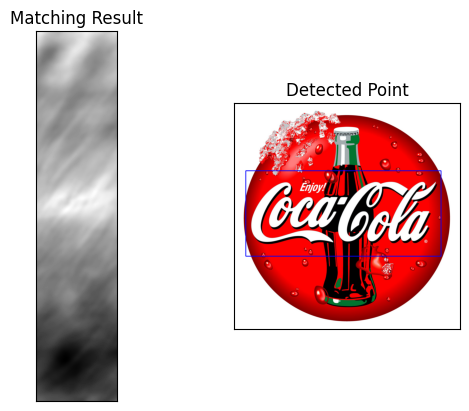

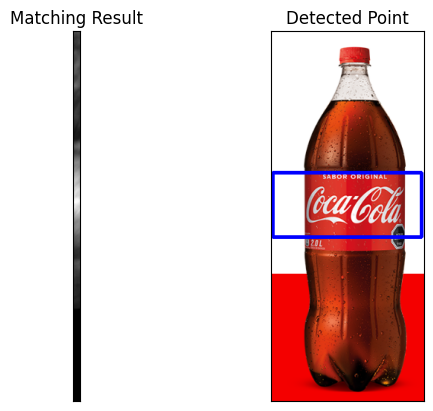

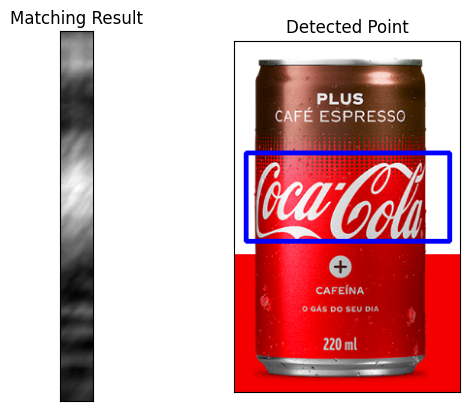

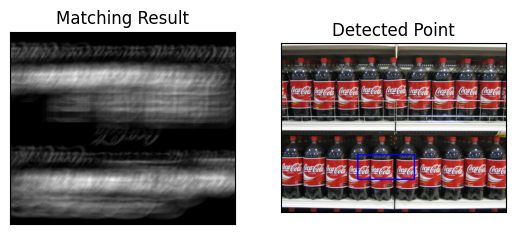

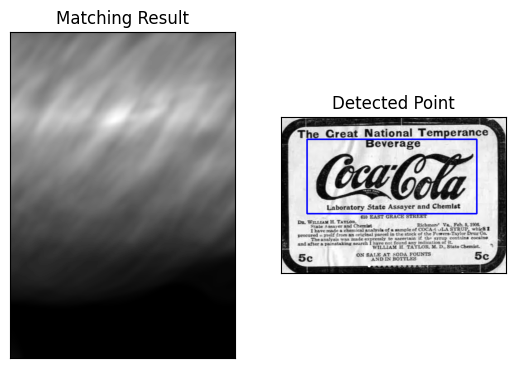

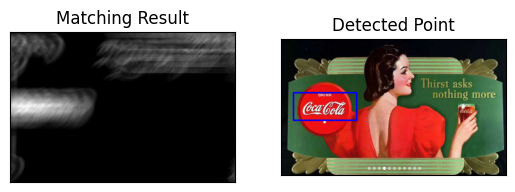

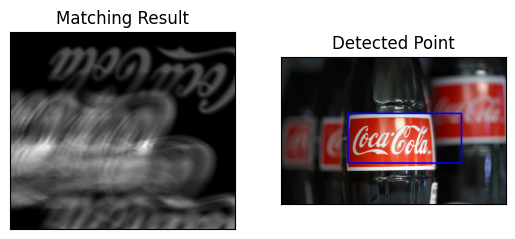

In [6]:
pattern = cv.imread('./template/pattern.png', 0)
detectar_logo()

2. Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1.

Text(0.5, 1.0, 'Resultado')

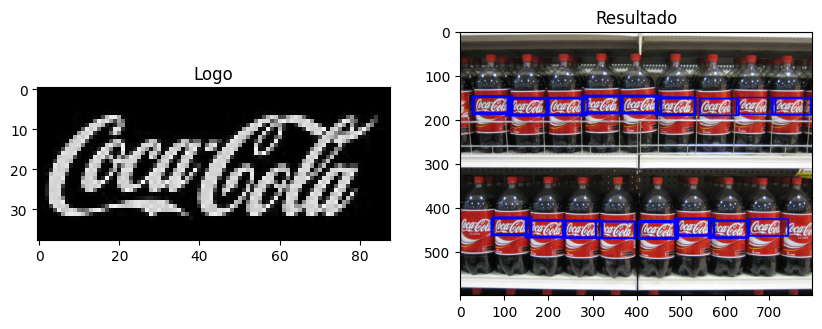

In [31]:
# Cargar y convertir imagenes
img = cv.imread('./images/coca_multi.png')
img_rgb  = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
pattern = cv.imread('./template/pattern.png', 0)
# Redimensionar y realizar inversión de colores en la plantilla
scale = 0.222
img_template = cv.bitwise_not(cv.resize(pattern, (int(pattern.shape[1] * scale), int(pattern.shape[0] * scale))))

w, h = img_template.shape[::-1]
# Realizar la coincidencia de plantillas 
res = cv.matchTemplate(img_gray, img_template, eval("cv.TM_CCORR_NORMED"))

# Encontrar las coordenadas donde el valor en el mapa de coincidencia es mayor o igual al umbral
threshold = 0.63
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

# Visualización
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img_template, cmap='gray')
plt.title('Logo')
plt.subplot(122)
plt.imshow(img_rgb)
plt.title('Resultado')

3. Generalizar el algoritmo del item 2 para todas las imágenes. Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

In [29]:
def detectar_logos():
    imgs_gray, images_color = import_img()
    max_value_list = []

    # Iterar sobre las imágenes en escala de grises y en color
    for i, j in zip(range(len(imgs_gray)), range(len(images_color))):
        best_detection = None
        best_max_val = 0

        # Redimensionar el logo en diferentes tamaños
        for scale in np.linspace(0.2, 3, 300):
            pattern_resized = cv.bitwise_not(cv.resize(pattern, (int(pattern.shape[1] * scale), int(pattern.shape[0] * scale))))
            
            # Verificar que el patrón redimensionado no sea más grande que la imagen en escala de grises
            if pattern_resized.shape[1] > imgs_gray[i].shape[1] or pattern_resized.shape[0] > imgs_gray[i].shape[0]:
                continue

            w, h = pattern_resized.shape[::-1]

            res = cv.matchTemplate(imgs_gray[i], pattern_resized, eval("cv.TM_CCORR_NORMED"))
            max_val = np.max(res)

            # Si la detección actual es mejor que la mejor detección hasta ahora, actualizar los valores
            if max_val > best_max_val:
                best_detection = (pattern_resized, w, h, res)
                best_max_val = max_val

        if best_detection is not None:
            pattern_resized, w, h, res = best_detection
            threshold = 0.63
            loc = np.where(res >= threshold)
            for pt in zip(*loc[::-1]):
                cv.rectangle(images_color[j], pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)

        # Mostrar los resultados 
        plt.subplot(121), plt.imshow(res, cmap='gray')
        plt.title('Matching Result'), plt.xticks([]), plt.yticks([])

        plt.subplot(122), plt.imshow(images_color[j])
        plt.title('Detected Point'), plt.xticks([]), plt.yticks([])

        plt.show()

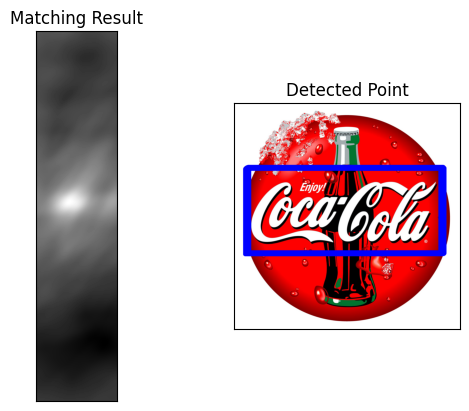

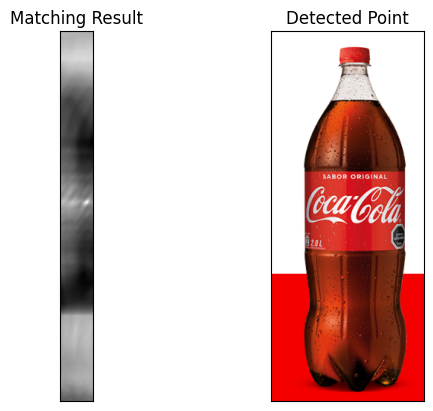

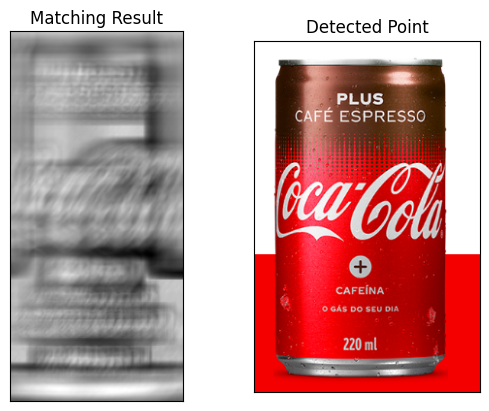

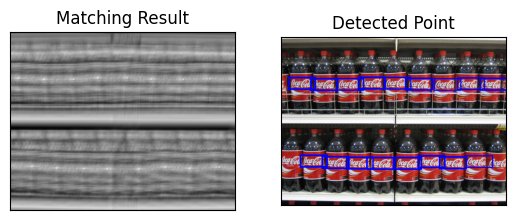

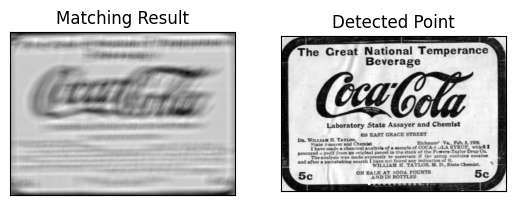

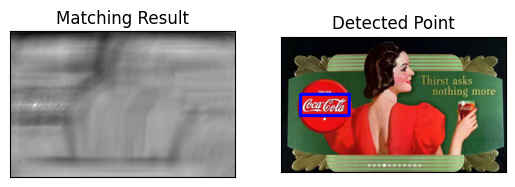

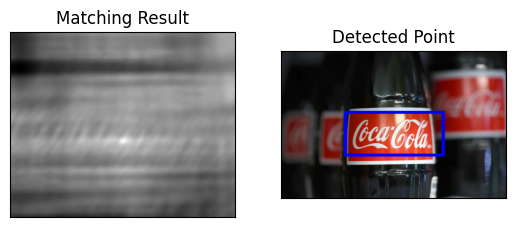

In [30]:
pattern = cv.imread('./template/pattern.png', 0)
detectar_logos()